<p style="background:#55185D; color:#F9D778; font-size: 2.1em; text-align:center"> 
    <br><br><b> Analysis of the Mental Health<br>
    <br>in the Tech Industry</b> <br><br>
    - Exploratory Data Analysis -<br><br>
</p>

<p style="text-align: right;">Module 2: Data Analysis<br>
Sprint 1: Introduction to SQL & Statistics Fundamentals<br>
Author : Renato Mariano</p>

<h1 style="color:#55185D">Introduction </h1>

This project is based on a dataset from Kagle of Mental Health in the Tech Industry. The scraped data is available on https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry. <br>

The data consists in surveys carried out in the years of 2014, 2016, 2017, 2018, 2019 on the Tech Workplace.

The scope of this project includes:
- Perform queries on the data using SQL.
- Perform Exploratory Data Analysis (EDA).
- Apply statistical inference procedures.
- Create Dashbord and Graphs to visualize and present the data.

<h2 style="color:#55185D">Questions </h2>

**The following questions based this analysis:**
1. What was the structure and application location of the survey?
2. Evaluating participant characteristics: age, gender, and race.
3. What percentage of participants currently or previously experienced mental health disorders?
4. Are there significant variations in mental health among participants based on their characteristics (age, gender, race)?
5. How does employment status, such as remote work and self-employment, impact mental health?
6. Does participants' willingness to discuss their mental health positively affect their well-being?
7. What is the overall sentiment of the participants towards the survey?


<h2 style="color:#55185D">Data processing </h2>

The analysis in this notebook were performed **question-wise**.

The following steps were carried out depending on the value/quality of the answers:
- Handling missing values.
- Removing duplicates.
- Treating/Acknoledging the outliers. 
- Analysis/conversion of data types. <br><br>

<h1 style="color:#55185D">Library Imports and Notebook Setup</h1>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import process

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
# Notebook setup
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML      # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
def clear_histplot(ax, plot_title="", plot_xlabel="", plot_ylabel="", legend_visibility=False):

    ax.set(xlabel=plot_xlabel, ylabel=plot_ylabel, title=plot_title)
    ax.set_title(plot_title, color='#31004a', fontsize=14)
    ax.tick_params(axis="both", which="both", length=0)  
    
    if not legend_visibility:
        ax.legend([],frameon=legend_visibility)

In [4]:
def clear_barplot(
    ax,
    percent,
    vertical=True,
    plot_title="",
    pad_top=13,
    pad_bottom=2,
    plot_xlabel="",
    plot_ylabel="",
    legend_visibility=False,
):

    ax.set(xlabel=plot_xlabel, ylabel=plot_ylabel)
    ax.set_title(plot_title, color="#31004a", fontsize=14)
    ax.tick_params(
        axis="both",
        which="both",
        length=0,
    )  # colors='#55185D'

    if not legend_visibility:
        ax.legend([],frameon=legend_visibility)
    
    if vertical:
        ax.set_yticklabels([])
        sns.despine(left=True)
    else:
        ax.set_xticklabels([])
        sns.despine(bottom=True)

    # Plot on top of the bars
    for c in ax.containers:
        ax.bar_label(c, padding=pad_top, color="#55185D", fontsize=10.5)
    if percent != 0:
        ax.bar_label(
            ax.containers[0],
            padding=pad_bottom,
            labels=percent,
            color="#55185D",
            fontsize=9,
        )

<h1 style="color:#55185D">Data Loading and Basic Queries</h1>

Here the 3 dataframes of the data set will be save in specific variables. The information about he tables will also be stored.

In [5]:
# Connect to the SQLite database
con = sqlite3.connect("data/mental_health.sqlite")

# Basic queries
table_query = "SELECT * FROM sqlite_master WHERE type='table';"
survey_query = "SELECT * FROM Survey;"
question_query = "SELECT * FROM Question;"
answer_query = "SELECT * FROM Answer;"

# Assigning variables
table = pd.read_sql(table_query, con)
survey = pd.read_sql(survey_query, con)
question = pd.read_sql(question_query, con)
answer = pd.read_sql(answer_query, con)

In [6]:
table.head()

,type,name,tbl_name,rootpage,sql
0,table,Answer,Answer,2,"CREATE TABLE ""Answer"" (\n\t""AnswerText"" VARCHA..."
1,table,Question,Question,1434,"CREATE TABLE ""Question"" (\n\t""questiontext"" VA..."
2,table,Survey,Survey,1438,"CREATE TABLE ""Survey"" (\n\t""SurveyID"" INTEGER ..."


In [7]:
for row in table["sql"]:
    print(row)

CREATE TABLE "Answer" (
	"AnswerText" VARCHAR(10000) NULL,
	"SurveyID" INTEGER NULL,
	"UserID" INTEGER NULL,
	"QuestionID" INTEGER NULL
)
CREATE TABLE "Question" (
	"questiontext" VARCHAR(1000) NULL,
	"questionid" INTEGER NULL
)
CREATE TABLE "Survey" (
	"SurveyID" INTEGER NOT NULL,
	"Description" VARCHAR(255) NULL,
	PRIMARY KEY ("SurveyID")
)


- The link between the tables Survey and Answer is made through SurveyID.
- The tables Question and Answer are linked through QuestionID.

In [8]:
survey.head()

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [9]:
question.head()

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5


In [10]:
answer.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


<h1 style="color:#55185D">Exploratory Data Analysis </h1>

<h2 style="color:#55185D">Survey Analysis</h2>

How did the number of questions and participants change by year?

In [11]:
num_survey_query = """SELECT DISTINCT SurveyID as Year, 
                             COUNT(DISTINCT UserID) as participants, 
                             COUNT(UserID) as answers
                      FROM Answer
                      GROUP BY Year"""
num_survey = pd.read_sql(num_survey_query, con=con)

num_question_query = """SELECT DISTINCT SurveyID as Year, 
                               COUNT(DISTINCT QuestionID) AS questions,
                               GROUP_CONCAT(DISTINCT QuestionID) AS UniqueQuestionIDs
                        FROM Answer
                        GROUP BY Year"""
num_questions = pd.read_sql(num_question_query, con=con)

In [12]:
num_questions

,Year,questions,UniqueQuestionIDs
0,2014,26,"1,2,3,4,5,6,7,8,9,10,11,12,90,91,92,93,94,95,9..."
1,2016,60,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
2,2017,76,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
3,2018,76,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
4,2019,76,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


In [13]:
num_survey

,Year,participants,answers
0,2014,1260,32760
1,2016,1433,88238
2,2017,756,57456
3,2018,417,31692
4,2019,352,26752


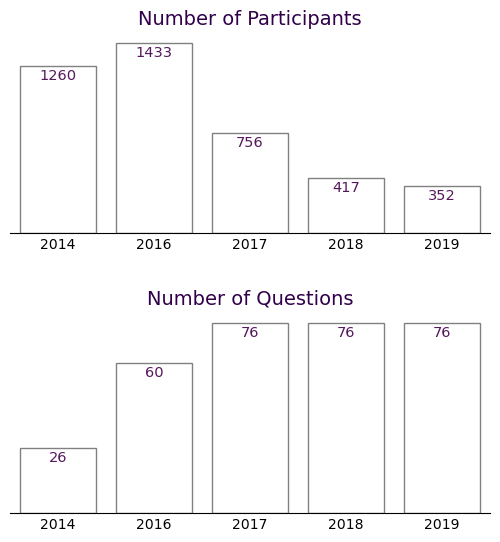

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

sns.barplot(
    x=num_survey["Year"],
    y=num_survey["participants"],
    color="lightgrey",
    fill=False,
    edgecolor="grey",
    ax=ax1,
)
sns.barplot(
    x=num_questions["Year"],
    y=num_questions["questions"],
    color="lightgrey",
    fill=False,
    edgecolor="grey",
    ax=ax2,
)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

clear_barplot(ax1, percent=0, pad_top=-12)
clear_barplot(ax2, percent=0, pad_top=-12)

ax1.set_title("Number of Participants", color="#31004a", fontsize=14)
ax2.set_title("Number of Questions", color="#31004a", fontsize=14);

- The survey had on the **first year only 26 questions**, not even the question 'Do you currently have a mental health disorder?' was presented.
- The survey was then improved, some questions were removed and new added.
- As to be seen in the cell bellow from the "question" table, **105 questions in total were presented** throughout the years.


- The **maximum number of participants was seen in 2016**.
- The number of participants decreased throughout the years.


In [15]:
question.count()

questiontext    105
questionid      105
dtype: int64

Another question that comes is **in which countries these surveys were applied**?

In [16]:
query = '''SELECT AnswerText AS Country,
                  COUNT(AnswerText) AS Frequency
            FROM Answer
            WHERE Answer.QuestionID = 3
            GROUP BY Country'''
country = pd.read_sql(query, con)
country.tail(7)

,Country,Frequency
74,United Kingdom,482
75,United States,751
76,United States of America,1853
77,Uruguay,2
78,Venezuela,1
79,Vietnam,1
80,Zimbabwe,1


The data seems to be consistent!!

USA however is divided in 2 rows.

In [17]:
# Combine the values of USA
combined_row = pd.DataFrame(
    {
        "Country": "United States of America",
        "Frequency": country.loc[country["Country"] == "United States"][
            "Frequency"
        ].values
        + country.loc[country["Country"] == "United States of America"][
            "Frequency"
        ].values,
    }
)
# Remove the original rows
country = country.drop(
    country[
        (country["Country"] == "United States")
        | (country["Country"] == "United States of America")
    ].index
)

# Append the combined row and order values
country = country.append(combined_row, ignore_index=True)
country = country.sort_values(by="Frequency", ascending=False)

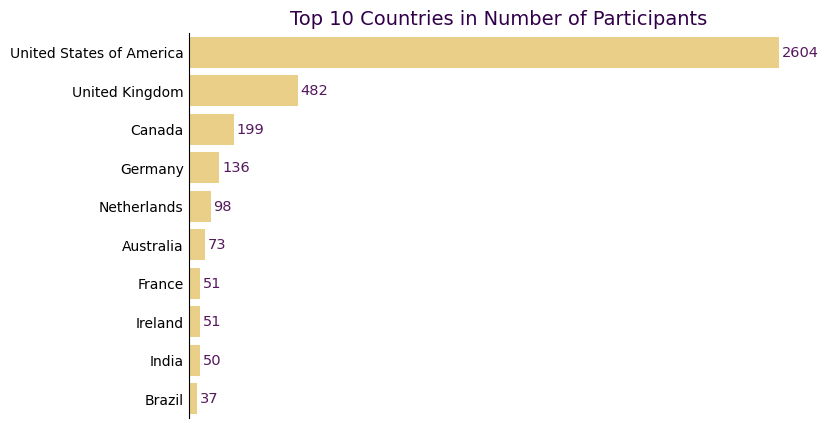

In [18]:
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.barplot(
    y="Country",
    x="Frequency",
    data=country.iloc[:10],
    color="#F9D778",
    ax=ax1,
)

clear_barplot(
    ax1,
    percent=0,
    vertical=False,
    plot_title="Top 10 Countries in Number of Participants",
    pad_top=2,
    pad_bottom=30,
)

From the above graph, one can take that the survey was carried out mostly in English speaking countries. United States, United Kingdom, Canada are presented in the top.

These countries are followed by Gemany and Netherlands.

In [19]:
english_speaking = country[
    country["Country"].str.contains(
        "United States|United Kingdom|Canada|Australia|Ireland"
    )
]
print(
    f'The English speaking countries amount to {round(100 * sum(english_speaking["Frequency"]) / sum(country["Frequency"]))}% of the respondents.\n'
)
print(
    f'The USA leads the number of participants with {round(100 * english_speaking["Frequency"].iloc[0] / sum(country["Frequency"]))}%.'
)

The English speaking countries amount to 81% of the respondents.

The USA leads the number of participants with 62%.


<h2 style="color:#55185D">Analysis on Mental Health Disorder</h2>

After having an overview of the survey, its participants and where it was applied, we can now dive deeper into the answers for the Mental Health Disorder.

**3 questions** provided a clear information about the **participants' mental health state** (Q32, Q33, Q34).

In [20]:
for index, row in question.iterrows():
    if index+1 in [32,33,34]:
        print(row['questionid'], row['questiontext'])

32 Have you had a mental health disorder in the past?
33 Do you currently have a mental health disorder?
34 Have you ever been diagnosed with a mental health disorder?


By using the table "num_questions" defined before, we see that **these 3 questions only started to be presented from the second year of survey**.

In [21]:
for i, col in enumerate(num_questions['UniqueQuestionIDs']):
    print('32,33,34' in num_questions['UniqueQuestionIDs'][i])

False
True
True
True
True


Besides, some other questions are also important for the analysis and will be imported to a single dataframe.

In [22]:
question_mapping = {
    'Age': 1,
    'Gender': 2,
    'Race':89,
    'Self-employment':5,
    'Work Position':117,
    'Remote Work':118,
    'MHD Current': 33,
    'MHD Past':32,
    'MHD Diagnosed':34,
    'Talk Coworkers':18,
    'Talk Supervisor':19,
    'Talk Family':30,
}

In [23]:
question_ids = list(question_mapping.values())
filtered_questions = question[question['questionid'].isin(question_ids)]

for index, row in filtered_questions.iterrows():
    print(row['questionid'], row['questiontext'])

1 What is your age?
2 What is your gender?
5 Are you self-employed?
18 Would you feel comfortable discussing a mental health issue with your coworkers?
19 Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?
30 How willing would you be to share with friends and family that you have a mental illness?
32 Have you had a mental health disorder in the past?
33 Do you currently have a mental health disorder?
34 Have you ever been diagnosed with a mental health disorder?
89 What is your race?
117 Which of the following best describes your work position?
118 Do you work remotely?


In [24]:
cols = ", ".join(
    f'GROUP_CONCAT(CASE WHEN QuestionID = {qid} THEN AnswerText END) AS "{col}"'
    for col, qid in question_mapping.items()
)

query = f""" SELECT UserID, {cols}
            FROM Answer
            GROUP BY UserID """

mental_health_df = pd.read_sql_query(query, con)
mental_health_df.head()

,UserID,Age,Gender,Race,Self-employment,Work Position,Remote Work,MHD Current,MHD Past,MHD Diagnosed,Talk Coworkers,Talk Supervisor,Talk Family
0,1,37,Female,None,-1,None,None,None,None,None,None,None,None
1,2,44,Male,None,-1,None,None,None,None,None,None,None,None
2,3,32,Male,None,-1,None,None,None,None,None,None,None,None
3,4,31,Male,None,-1,None,None,None,None,None,None,None,None
4,5,31,Male,None,-1,None,None,None,None,None,None,None,None


All of the data is of object type (exc. UserID). Age should however be converted.

Some **data cleaning is required**:
- Age presents values higher than 100 years old.
- It also presents negative values,
- To some of the columns, the value -1 was attributed as Null.

The description of the data bellow shows that:
- The most common participants has an age of 30 years old, Male, white.
- **Most of the participants declare to have suffered form Mental Health issues** in the past, or to have it currently.

In [25]:
mental_health_df.describe(include='object')

,Age,Gender,Race,Self-employment,Work Position,Remote Work,MHD Current,MHD Past,MHD Diagnosed,Talk Coworkers,Talk Supervisor,Talk Family
count,4218,4218,1525,4218,1433,1433,2958,2958,2958,2958,2958,2958
unique,65,101,11,3,264,3,5,6,3,4,4,6
top,30,Male,White,0,Back-end Developer,Sometimes,Yes,Yes,Yes,Maybe,Yes,Very open
freq,250,2830,873,3550,263,757,1237,1417,1363,1053,932,1104


In [26]:
# Transformation of age into integer
mental_health_df['Age'] = mental_health_df['Age'].astype('int')

# Check if values surpass 100 years or are lower than 0?
mental_health_df[(mental_health_df['Age'] < 0) | (mental_health_df['Age'] > 100)]

# Attribute NA to these values
mental_health_df[(mental_health_df['Age'] < 0) | (mental_health_df['Age'] > 100)] = np.nan

In [27]:
# Transformation of -1 to Null
mental_health_df.replace('-1', np.nan, inplace=True)

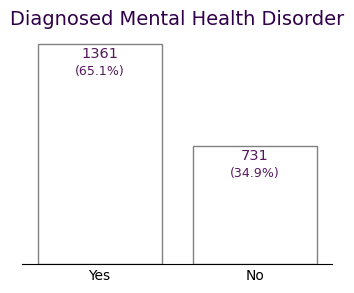

In [28]:
fig, ax1 = plt.subplots(figsize=(4, 3))

sns.barplot(
    x=mental_health_df["MHD Diagnosed"].value_counts().index,
    y=mental_health_df["MHD Diagnosed"].value_counts(),
    color="#F9D778",    
    fill=False,
    edgecolor="grey",
    ax=ax1,
)

# Calculate percentages of each gender
percentage = round(
    100
    * mental_health_df["MHD Diagnosed"].value_counts()
    / sum(mental_health_df["MHD Diagnosed"].value_counts()),
    1,
).tolist()
percentage = [f"({x}%)" for x in percentage]

clear_barplot(ax1, percentage, pad_top=-12, pad_bottom=-24, plot_title="Diagnosed Mental Health Disorder")

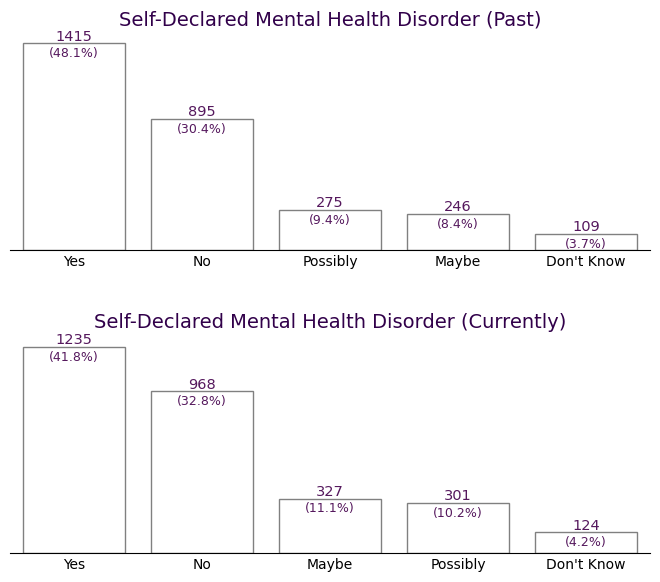

In [29]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6.5)) #  sharey="row",

sns.barplot(
    x=mental_health_df['MHD Past'].value_counts().index,
    y=mental_health_df['MHD Past'].value_counts(),
    color='lightgrey',
    fill=False,
    edgecolor="grey",
    ax=ax1,
)

sns.barplot(
    x=mental_health_df['MHD Current'].value_counts().index,
    y=mental_health_df['MHD Current'].value_counts(),
    color='#F9D778',
    fill=False,
    edgecolor="grey",
    ax=ax2,
)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

# Calculate percentages of each gender
percentage = round(100 * mental_health_df['MHD Past'].value_counts() / sum(mental_health_df['MHD Past'].value_counts()), 1).tolist()
percentage = [f"({x}%)" for x in percentage]

percentage2 = round(100 * mental_health_df['MHD Current'].value_counts() / sum(mental_health_df['MHD Current'].value_counts()), 1).tolist()
percentage2 = [f"({x}%)" for x in percentage2]

clear_barplot(ax1, percentage, plot_title="Self-Declared Mental Health Disorder (Past)", pad_top=0, pad_bottom=-12)
clear_barplot(ax2, percentage2, plot_title="Self-Declared Mental Health Disorder (Currently)", pad_top=0, pad_bottom=-12)

- **65% of the respondents** affirm to have been **diagnosed** with some mental health desease in the past.
- Around 48% declare to have suffered from it in the past and 42% to present some degree of mental disorder currently.
- Around 20% are not sure if they have had or have mental health issues ("Maybe" and "Possibly" answers).


(Disclaimer: the analysis includes participants that took the survey in different years!!)

Following we will analyse how the mental health disorder is influenced by the participants characteristics, like age and gender, as well as by the employment characteristics.

We will use the answers regarding their current mental health situation for analysis. 

'Maybe' and 'Possibly' answers will be grouped as 'Yes'. 'Don't know' will be considered 'No'.

In [30]:
mental_health_df["MHD Current"] = mental_health_df["MHD Current"].replace(
    {"Yes": "Yes", "No": "No", "Maybe": "Yes", "Possibly": "Yes", "Don't Know": "No"}
)
mental_health_df["MHD Current"].value_counts()

Yes    1863
No     1092
Name: MHD Current, dtype: int64

<h3 style="color:#55185D">Age </h3>

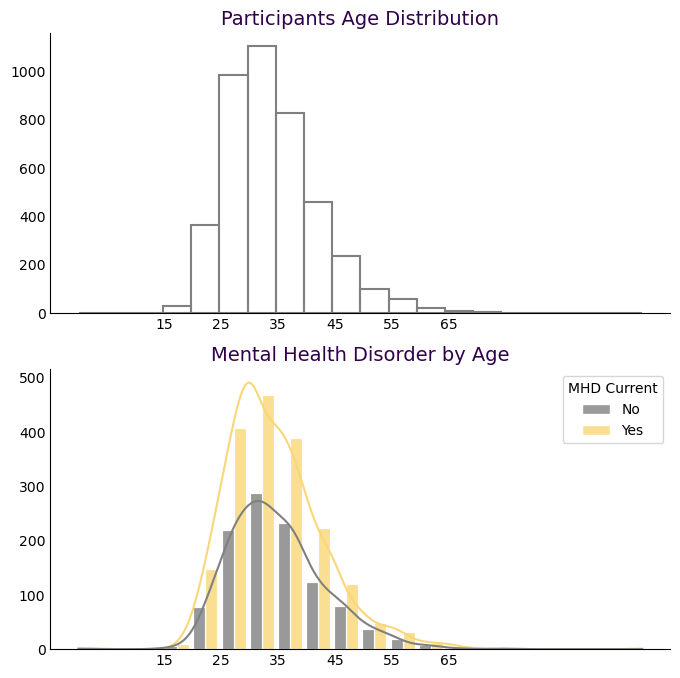

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 8)) #  sharey="row",

sns.histplot(
    x=mental_health_df['Age'],
    #kde=True,
    bins=20,
    color='grey',
    fill=False,
    ax=ax1,
)

sns.histplot(
    data=mental_health_df.loc[~mental_health_df["MHD Current"].isna(), ["Age", "MHD Current"]],
    x="Age",
    hue="MHD Current",
    multiple="dodge",
    shrink=0.85,
    bins=20,
    palette=['grey',"#F9D778"],
    edgecolor="white",
    alpha=0.8,
    kde=True,
    ax=ax2,
)

#ax1.lines[0].set_color('black')
ax1.set_xticks(range(15, 75, 10))
ax2.set_xticks(range(15, 75, 10))

sns.despine()
clear_histplot(ax1, "Participants Age Distribution")
clear_histplot(ax2, "Mental Health Disorder by Age", legend_visibility=True);

Most of the respondents are between 25 and 40 years old.

No visual difference is to be seen amongst the different age groups. The proportions between previously diagnosed with a mental health disease and not seem very stable.

<h3 style="color:#55185D">Gender</h3>

In [32]:
# Mapping out the most of the variations that were input for gender
gender_mapping = {
    "female": "Female",
    "woman": "Female",
    "male": "Male",
    "man": "Male",
    "she/her": "Female",
    "he/him": "Male",
    "masculine": "Male",
    "guy": "Male",
    "m2f": "Female",
    "fm": "Female",
    "male-ish": "Male",
    "intersex": "Intersex",
    "non-binary": "Intersex",
    "non binary": "Intersex",
    "nonbinary": "Intersex",
    "nb": "Intersex",
    "neuter": "Intersex",
    "nah": "Intersex",
    "none": "Intersex",
    "genderqueer": "Intersex",
    "agender": "Intersex",
    "queer": "Intersex",
    "afab": "Intersex",
    "enby": "Intersex",
    "genderfluid": "Intersex",
    "human": "Intersex",
    "all": "Intersex",
    "androgynous": "Intersex",
    "androgyne": "Intersex",
    "demiguy": "Intersex",
    "demiboy": "Intersex",
    "demigirl": "Intersex",
    "bigender": "Intersex",
    "genderflux": "Intersex",
    "other": "Intersex",
}

similarity_threshold = 85

# Create Gender_Category
mental_health_df["Gender_Category"] = mental_health_df["Gender"]

# Attribute the similar pattern and the similarity percentage to Gender_Category
mental_health_df["Gender_Category"][
    mental_health_df["Gender"].notna()
] = mental_health_df["Gender"][mental_health_df["Gender"].notna()].apply(
    lambda x: process.extractOne(x.lower(), gender_mapping.keys())
)

# if the similarity is greater than the threshold, then apply.
mental_health_df["Gender_Category"][
    mental_health_df["Gender"].notna()
] = mental_health_df["Gender_Category"][mental_health_df["Gender"].notna()].apply(
    lambda x: gender_mapping[x[0]] if x[1] >= similarity_threshold else "Invalid Answer"
)

In [33]:
mental_health_df[['Gender','MHD Current', 'Gender_Category']].tail()

,Gender,MHD Current,Gender_Category
4213,male,Yes,Male
4214,Male,No,Male
4215,Male,No,Male
4216,female,Yes,Female
4217,Female,Yes,Female


In [34]:
gender_freq = (
    mental_health_df[mental_health_df["Gender_Category"] != "Invalid Answer"]
    .groupby("Gender_Category")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Frequency")
    .reset_index()
)
gender_freq

,Gender_Category,Frequency
0,Male,3053
1,Female,1048
2,Intersex,71


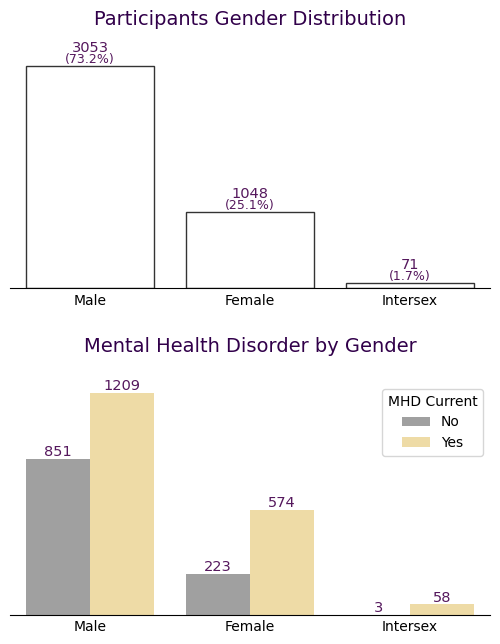

In [35]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 7)) #  sharey="row",

sns.barplot(
    x=gender_freq["Gender_Category"],
    y=gender_freq["Frequency"],
    fill=False,
    alpha=0.8,
    ax=ax1,
)

sns.countplot(
    mental_health_df["Gender_Category"][mental_health_df["Gender_Category"] != "Invalid Answer"],
    hue=mental_health_df["MHD Current"],
    order=gender_freq["Gender_Category"],
    palette=['grey',"#F9D778"],
    alpha=0.75,
    ax=ax2,
)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

# Calculate percentages
percentage = round(100 * gender_freq["Frequency"] / sum(gender_freq["Frequency"]), 1).tolist()
percentage = [f"({x}%)" for x in percentage]

clear_barplot(ax1, percentage, plot_title="Participants Gender Distribution\n", pad_top=8, pad_bottom=0)
clear_barplot(ax2, percent=0, plot_title="Mental Health Disorder by Gender\n", legend_visibility=True, pad_top=0);

**Gender**

As expected, most of the survey participants are male (72.5%), which reflects well the uneven distribution of gender in tech industry.

Moreover, 
- the proportion of females who have had diagnosed mental health disease (MHD) is about 72%. 
- 95% of the Intersex group also had MHD.
- For males this proportion is reduced to 58%.

This highlights how the minorities groups suffer more from mental diseases.

<h3 style="color:#55185D">Race</h3>

The Question 88 (What is your race?) took place from the 3rd survey on. 

A separate query will be implemented so that the null values from the first 2 surveys will not influence the analysis.

In [36]:
query = '''SELECT AnswerText AS Answer,
                  COUNT(AnswerText) AS Frequency
            FROM Answer
            WHERE Answer.QuestionID = 89
            GROUP BY Answer'''
race = pd.read_sql(query, con).sort_values(by='Frequency', ascending=False)
race

,Answer,Frequency
9,White,873
0,-1,537
8,More than one of the above,35
2,Asian,31
7,I prefer not to answer,29
3,Black or African American,15
1,American Indian or Alaska Native,1
4,Caucasian,1
5,European American,1
6,Hispanic,1


In [37]:
mental_health_df[mental_health_df['Race'].isna()].shape[0]

3230

**Race**

The evaluation of the race groups is not very conclusive.

In [38]:
print("A great proportion of the respondents did not provide the race: ")
print(f"{100 * race['Frequency'][race['Answer']=='-1'].values[0] / race['Frequency'].sum():.1f}%\n")

print("The major group of respondents declare themselves as white: ")
print(f"{100 * race['Frequency'][race['Answer']=='White'].values[0] / race['Frequency'].sum():.1f}%")

A great proportion of the respondents did not provide the race: 
35.2%

The major group of respondents declare themselves as white: 
57.2%


<h3 style="color:#55185D">Employment</h3>

Here the following features were evaluated Self-employment, Remote work.

In [39]:
# Store of columns in frequency tables
remote_work = (
    mental_health_df.groupby("Remote Work")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Frequency")
    .reset_index()
)

self_employed = (
    mental_health_df.groupby("Self-employment")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Frequency")
    .reset_index()
)
self_employed

,Self-employment,Frequency
0,0,3546
1,1,646


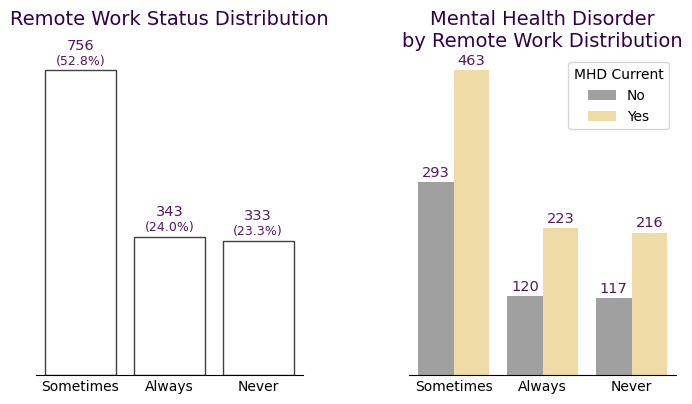

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(
    x="Remote Work",
    y="Frequency",
    data=remote_work,
    fill=False,
    alpha=0.75,
    ax=ax1,
)

sns.countplot(
    mental_health_df["Remote Work"],
    hue=mental_health_df["MHD Current"],
    order=remote_work["Remote Work"],
    palette=['grey',"#F9D778"],
    alpha=0.75,
    ax=ax2,
)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Calculate percentages
percentage = round(
    100 * remote_work["Frequency"] / sum(remote_work["Frequency"]), 1
).tolist()
percentage = [f"({x}%)" for x in percentage]


clear_barplot(ax1, percentage, plot_title="Remote Work Status Distribution\n")
clear_barplot(
    ax2,
    percent=0,
    plot_title="Mental Health Disorder\nby Remote Work Distribution",
    pad_top=2,
    legend_visibility=True,
)

**Remote Work**
- Most of the participants are working partially remotely. Only about 23% affirm to carry their activities completely in the office.
- The proportion of participants who have been diagnosed with mental health disease in the past is very even throughout the groups (between 60% and 65%).

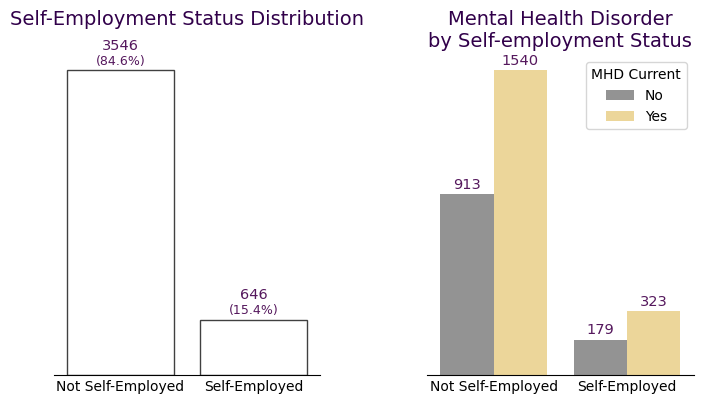

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(
    x="Self-employment",
    y="Frequency",
    data=self_employed,
    fill=False,
    alpha=0.75,
    ax=ax1,
)

sns.countplot(
    mental_health_df["Self-employment"],
    hue=mental_health_df["MHD Current"],
    order=self_employed["Self-employment"],
    palette=["grey", "#F9D778"],
    alpha=0.85,
    ax=ax2,
)

ax1.set_xticks([0, 1])
ax1.set_xticklabels(["Not Self-Employed", "Self-Employed"])
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["Not Self-Employed", "Self-Employed"])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

percentage = round(
    100 * self_employed["Frequency"] / sum(self_employed["Frequency"]), 1
).tolist()
percentage = [f"({x}%)" for x in percentage]

clear_barplot(ax1, percentage, plot_title="Self-Employment Status Distribution\n")
clear_barplot(ax2, percent=0, plot_title="Mental Health Disorder\nby Self-employment Status", pad_top=2, legend_visibility=True)

**Self-employment**
- Only 15% of the respondents are self-employed.
- The proportion of people who have MHD is also very even in both groups, about 64%.

<h3 style="color:#55185D">Openness regarding Mental Health</h3>

Here the ability of opening up about their mental disorder was evaluated.

In [42]:
talk_coworkers = (
    mental_health_df.groupby("Talk Coworkers")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Frequency")
    .reset_index()
)

talk_supervisor = (
    mental_health_df.groupby("Talk Supervisor")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Frequency")
    .reset_index()
)

talk_family = (
    mental_health_df.groupby("Talk Family")
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Frequency")
    .reset_index()
)
talk_coworkers

,Talk Coworkers,Frequency
0,Maybe,1052
1,No,719
2,Yes,682


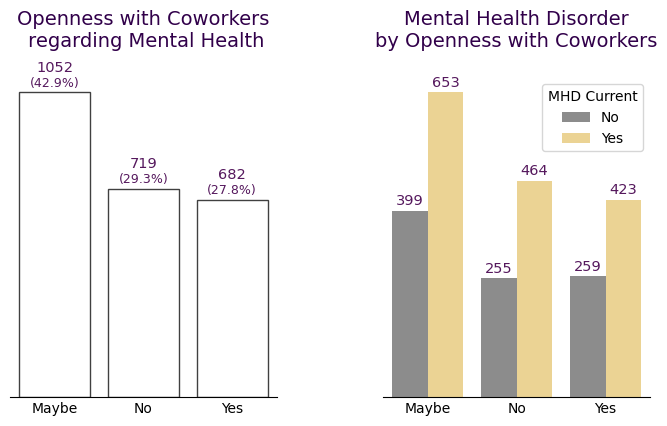

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(
    x="Talk Coworkers",
    y="Frequency",
    data=talk_coworkers,
    fill=False,
    alpha=0.75,
    ax=ax1,
)

sns.countplot(
    mental_health_df["Talk Coworkers"],
    hue=mental_health_df["MHD Current"],
    order=talk_coworkers["Talk Coworkers"],
    palette=['grey',"#F9D778"],
    alpha=0.9,
    ax=ax2,
)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Calculate percentages
percentage = round(
    100 * talk_coworkers["Frequency"] / sum(talk_coworkers["Frequency"]), 1
).tolist()
percentage = [f"({x}%)" for x in percentage]

clear_barplot(
    ax1, percentage, plot_title="Openness with Coworkers\n regarding Mental Health\n"
)
clear_barplot(
    ax2,
    percent=0,
    plot_title="Mental Health Disorder\nby Openness with Coworkers\n",
    pad_top=2,
    legend_visibility=True,
)

**Openness with Coworkers**
- Circa 28% of the participants declare being open to talk to coworkers about their mental health. Considering the 'Maybe' group this proportion increases to 70%.
- Here again no effective difference can be found in the groups. Proportions vary between 62% and 64%.

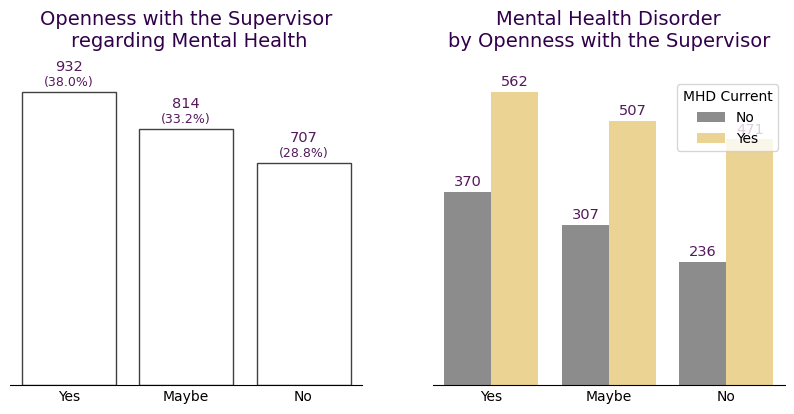

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(
    x="Talk Supervisor",
    y="Frequency",
    data=talk_supervisor,
    fill=False,
    alpha=0.75,
    ax=ax1,
)

sns.countplot(
    mental_health_df["Talk Supervisor"],
    hue=mental_health_df["MHD Current"],
    order=talk_supervisor["Talk Supervisor"],
    palette=['grey',"#F9D778"],
    alpha=0.9,
    ax=ax2,
)

#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Calculate percentages
percentage = round(
    100 * talk_supervisor["Frequency"] / sum(talk_supervisor["Frequency"]), 1
).tolist()
percentage = [f"({x}%)" for x in percentage]

clear_barplot(
    ax1, percentage, plot_title="Openness with the Supervisor\n regarding Mental Health\n"
)
clear_barplot(
    ax2,
    percent=0,
    plot_title="Mental Health Disorder\nby Openness with the Supervisor\n",
    pad_top=2,
    legend_visibility=True,
)

**Openness with Supervisor**
- The openness to talk about MHD with the supervisor increases to 38%.
- Here the group of people who is not open is slightly having more MH issues, 66% in relation to the other groups 60% (yes) and 62% (maybe).

In [45]:
talk_family

,Talk Family,Frequency
0,Very open,1103
1,Somewhat open,791
2,Not open at all,331
3,Neutral,328
4,Somewhat not open,290
5,Not applicable to me (I do not have a mental i...,112


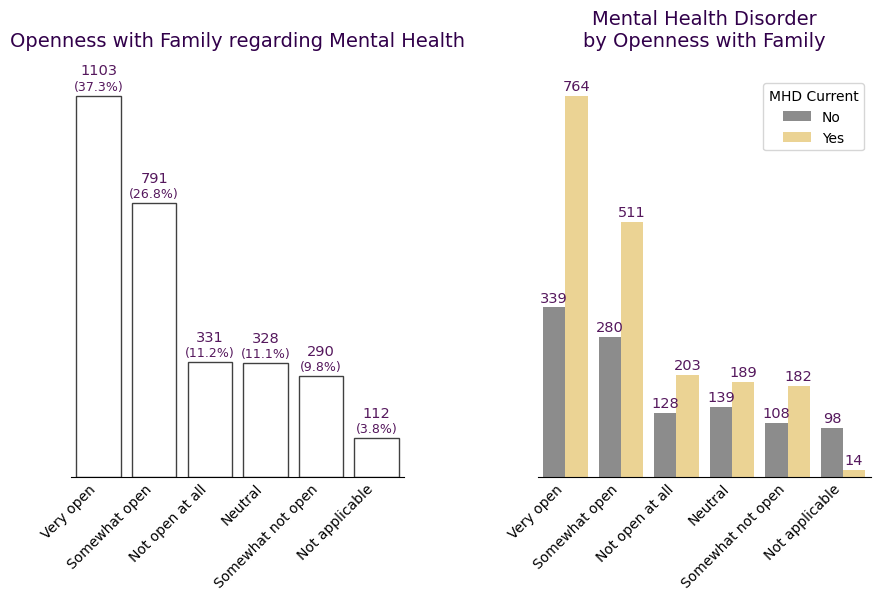

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(
    x="Talk Family",
    y="Frequency",
    data=talk_family,
    fill=False,
    alpha=0.75,
    ax=ax1,
)

sns.countplot(
    mental_health_df["Talk Family"],
    hue=mental_health_df["MHD Current"],
    order=talk_family["Talk Family"],
    palette=['grey',"#F9D778"],
    alpha=0.9,
    ax=ax2,
)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Get the current tick labels
xtick_labels = ax2.get_xticklabels()

# Modify the value at the 5th index
xtick_labels[5] = "Not applicable"
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax2.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Calculate percentages
percentage = round(
    100 * talk_family["Frequency"] / sum(talk_family["Frequency"]), 1
).tolist()
percentage = [f"({x}%)" for x in percentage]

clear_barplot(
    ax1, percentage, plot_title="Openness with Family regarding Mental Health\n"
)
clear_barplot(
    ax2,
    percent=0,
    plot_title="Mental Health Disorder\nby Openness with Family\n",
    pad_top=2,
    legend_visibility=True,
)

**Openness with Family**
- The openness to talk about MHD with a family member amounts to 64% (Very open and Somewhat open groups).
- About 4% of the participants marked the option that they don't have a MHD. 14 of them are however are classified as having it (which might come from 'maybe' and 'possibly' converted to yes in the currently MHD question).


- It is interesting to notice from the right graph that the proportion of people currently with MHD increases with the willingness to talk (69%, 64% 61%...). Maybe because they recognize the importance of opening up in the process of getting better.

In [47]:
def divisao (y, n):
    print(y/(y+n))
    
divisao(203,128)

0.6132930513595166


<h3 style="color:#55185D">Open Answers</h3>

This section will dive a little bit into the open answer provided by the respondents in question 87

In [48]:
print(question['questiontext'][question['questionid']==87].values)

['If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.']


In [49]:
query = ''' SELECT AnswerText AS Answer
            FROM Answer
            WHERE Answer.QuestionID = 87'''
open_talk = pd.read_sql(query, con)
open_talk.tail(7)

,Answer
1518,-1
1519,reasons for mental health issues should be cov...
1520,-1
1521,-1
1522,sdsdsdsdsdsd
1523,no
1524,I've had to drive all of the progress in menta...


In [50]:
# Limit the minimum size for relevancy of the answers
open_talk = open_talk[open_talk['Answer'].str.len()>15]

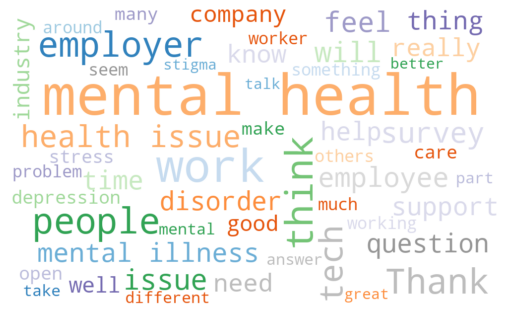

In [51]:
from wordcloud import WordCloud
text = open_talk['Answer'].values
wordcloud = WordCloud(
    background_color="white", colormap="tab20c", width=1000, height=600, max_words=50, min_word_length=4).generate(str(text))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

By the word cloud, we see that there is a feeling of gratitude torwards the people involved in the survey (word: **Thank**).
As expected, similar words to **mental health (disorder)** are to be found very often through the text.
The words **talk** and **help** are also there maybe showing that discussing about mental health or asking for help is not an easy thing for the respondents. There is a lot of **stigma** still associated with these **issues**.

Next a short sentiment analysis was performed using the Natural Language Toolkit (NLTK).

In [52]:
# VADER lexicon already downloaded!
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()  # Initialization

# Apply find the polarity for each response
open_talk["Sentiment"] = open_talk["Answer"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Classify the polarity based on the score
open_talk["Sentiment_Label"] = open_talk["Sentiment"].apply(
    lambda x: "Positive" if x >= 0.05 else "Negative" if x <= -0.05 else "Neutral"
)

open_talk.head()

,Answer,Sentiment,Sentiment_Label
11,People with mental disorders can be just as pr...,0.9432,Positive
17,Good mental health is vital to complete good q...,0.9360,Positive
19,Speaking openly about anything that might be c...,0.8591,Positive
29,How can I see your findings?,0.0000,Neutral
37,Admitting you have a mental illness is the fir...,-0.4019,Negative


In [53]:
round(100 * open_talk['Sentiment_Label'].value_counts()/sum(open_talk['Sentiment_Label'].value_counts()),1)

Positive    56.1
Negative    31.4
Neutral     12.6
Name: Sentiment_Label, dtype: float64

Most of the answer have a posite conotation (56%).

Let's take a look to see if we find some specific answer that highlight the importance of talking about mental health.

In [54]:
open_talk[open_talk['Sentiment'] > 0.9]

,Answer,Sentiment,Sentiment_Label
11,People with mental disorders can be just as pr...,0.9432,Positive
17,Good mental health is vital to complete good q...,0.9360,Positive
164,My current work experiences are tempered by th...,0.9396,Positive
723,"In my previous job, getting questioned for the...",0.9359,Positive
834,Thank you for the good work you do to help peo...,0.9184,Positive
841,I think I gave the tech sector 3 stars for dea...,0.9168,Positive
853,"Yes, the first question ""self-employed"" should...",0.9316,Positive
1020,The greatest point of stress in managing peopl...,0.9064,Positive
1084,It's only as I've gotten older that I'm accept...,0.9074,Positive
1086,I revealed my ADHD diagnosis to my supervisor ...,0.9695,Positive


In [55]:
#open_talk['Answer'][1084]

One very impactant part of this answer was:

**I felt relieved when I found out others in my life had similar mental health issues as I do.**

In [56]:
open_talk[open_talk['Sentiment'] < -0.8]

,Answer,Sentiment,Sentiment_Label
241,I have a huge amount of anger and depression a...,-0.8102,Negative
249,I'd like to see a more open discussion in the ...,-0.8381,Negative
267,Please think very hard about women/POC and men...,-0.8655,Negative
315,"I wish we could change things, but the bottom ...",-0.8160,Negative
447,Living with mental illness is already a strugg...,-0.9100,Negative
508,I don't feel like I'm any kind of authority on...,-0.9778,Negative
566,Some people in tech blog bravely about their m...,-0.8689,Negative
624,I had a boss so bad and micromanaging that I h...,-0.8122,Negative
665,I feel the IT industry gets labeled as a 'low ...,-0.9486,Negative
857,tech companies are largely responsible for gun...,-0.9485,Negative


In [57]:
#open_talk['Answer'][566]

**Whatever stigma there is about mental health in tech, it is far worse for women**

<h1 style="color:#55185D">Conclusions </h1>

   - The survey experienced variations in the number of questions and participants across different years, with the highest participation rate observed in 2016.


   - A majority of the participants reside in the United States or English-speaking countries.
   - The most prevalent group among participants consisted of white men around the age of 30.


   - Past mental health diagnoses were reported by approximately 65% of respondents, while the current proportion of individuals with a mental health disorder (MHD) stood at 42%. When considering the "possibly" and "maybe" categories, this proportion increased to 63%.


   - The prevalence of MHD did not exhibit significant changes across different age groups or in relation to the evaluated employment characteristics.
   - Women (72%) and individuals identifying as intersex (95%) displayed a notably higher proportion of MHD compared to men (58%), highlighting the increased vulnerability of minority groups to mental health conditions.
    

   - The willingness to discuss mental health issues did not appear to have a significant impact on the proportion of participants with MHD, except in the case of openness with family members. A greater proportion of individuals who were more open in this aspect tended to have some degree of MHD.


   - Overall, the open responses conveyed a positive sentiment towards the survey.
   
Besides, the dataset is very rich and a lot of analysis could still be done on the data.


In [59]:
for index, row in open_talk.iterrows():
    if index in [17, 1509, 1257]:
        print(f"Sentiment: {row['Sentiment']}, \n, row['Answer'].replace('.','.\n'), \n")

Sentiment: 0.936, 
, row['Answer'].replace('.','.
'), 

Sentiment: 0.923, 
, row['Answer'].replace('.','.
'), 

Sentiment: 0.9314, 
, row['Answer'].replace('.','.
'), 



In [60]:
for index, row in open_talk.iterrows():
    if index in [17, 1509, 1257]:
        print(f"Sentiment: {row['Sentiment']}", "\n", row['Answer'].replace('.','.\n'), "\n")

Sentiment: 0.936 
 Good mental health is vital to complete good quality work and even people without for mental health issues need support at times.
 Long term and short term burnout is common and I believe needs better acknowledgement and support.
 

Sentiment: 0.923 
 The distinction between suffering a mental illness and being considerate of ones mental health is very important and increasingly misrepresented to the great determent of the care and understanding offered to those with a neurologically situated illness.
 Like many well meaning efforts in the arena of mental health this servery doesn't recognize that the support and care of others including partners and children can be an imposition to work and employment.
 

Sentiment: 0.9314 
 I answered using your “disordered = doctor diagnosed” so I said no to some questions.
 But I surely have “mental health issues” and would have answered yes to those questions.
 But you only asked about diagnoses disorders.
 You are leaving out a